<div align="center">

#### Lab 3

# National Tsing Hua University

#### Spring 2025

#### 11320IEEM 513600

#### Deep Learning and Industrial Applications
    
## Lab 3: Anomaly Detection in Industrial Applications

</div>

### Introduction

In today's industrial landscape, the ability to detect anomalies in manufacturing processes and products is critical for maintaining quality, efficiency, and safety. This lab focuses on leveraging deep learning techniques for anomaly detection in various industrial applications, using the MVTEC Anomaly Detection Dataset. By employing ImageNet-pretrained models available in torchvision, students will gain hands-on experience in classfying defects and irregularities across different types of industrial products.

Throughout this lab, you'll be involved in the following key activities:
- Explore and process the MVTec Anomaly Detection Dataset.
- Apply ImageNet-pretrained models from [Torchvision](https://pytorch.org/vision/stable/models.html) to detect anomalies in industrial products.
- Evaluate the performance of the models to understand their effectiveness in real-world industrial applications.

### Objectives

- Understand the principles of anomaly detection in the context of industrial applications.
- Learn how to implement and utilize ImageNet-pretrained models for detecting anomalies.
- Analyze and interpret the results of the anomaly detection models to assess their practicality in industrial settings.

### Dataset

The MVTec AD Dataset is a comprehensive collection of high-resolution images across different categories of industrial products, such as bottles, cables, and metal nuts, each with various types of defects. This dataset is pivotal for developing and benchmarking anomaly detection algorithms. You can download our lab's dataset [here](https://drive.google.com/file/d/19600hUOpx0hl78TdpdH0oyy-gGTk_F_o/view?usp=share_link). You can drop downloaded data and drop to colab, or you can put into yor google drive.

### References
- [MVTec AD Dataset](https://www.kaggle.com/datasets/ipythonx/mvtec-ad/data) for the dataset used in this lab.
- [Torchvision Models](https://pytorch.org/vision/stable/models.html) for accessing ImageNet-pretrained models to be used in anomaly detection tasks.
- [State-of-the-Art Anomaly Detection on MVTec AD](https://paperswithcode.com/sota/anomaly-detection-on-mvtec-ad) for insights into the latest benchmarks and methodologies in anomaly detection applied to the MVTec AD dataset.
- [CVPR 2019: MVTec AD — A Comprehensive Real-World Dataset for Unsupervised Anomaly Detection] for the original paper of MVTec AD dataset.

In [1]:
import glob
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import cv2
import numpy as np
from collections import defaultdict
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import models
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm

In [2]:


# 設定本地資料根目錄
base_dir = r'D:\python\DP\HW3\capsule'

# 找 train 圖片
train_paths = glob.glob(os.path.join(base_dir, 'train', '*', '*.png'))

# 找 test 圖片
test_paths = glob.glob(os.path.join(base_dir, 'test', '*', '*.png'))

# 找 ground truth 缺陷遮罩
gt_paths = glob.glob(os.path.join(base_dir, 'ground_truth', '*', '*.png'))

print(f"Train 圖片數量：{len(train_paths)}")
print(f"Test 圖片數量：{len(test_paths)}")
print(f"Ground Truth 圖片數量：{len(gt_paths)}")


Train 圖片數量：219
Test 圖片數量：132
Ground Truth 圖片數量：109


Loading images: 100%|██████████| 140/140 [00:02<00:00, 63.63it/s]


讀入圖片總數：140, shape: (140, 1000, 1000, 3)
類別種類：['crack' 'faulty_imprint' 'good' 'poke' 'scratch' 'squeeze']


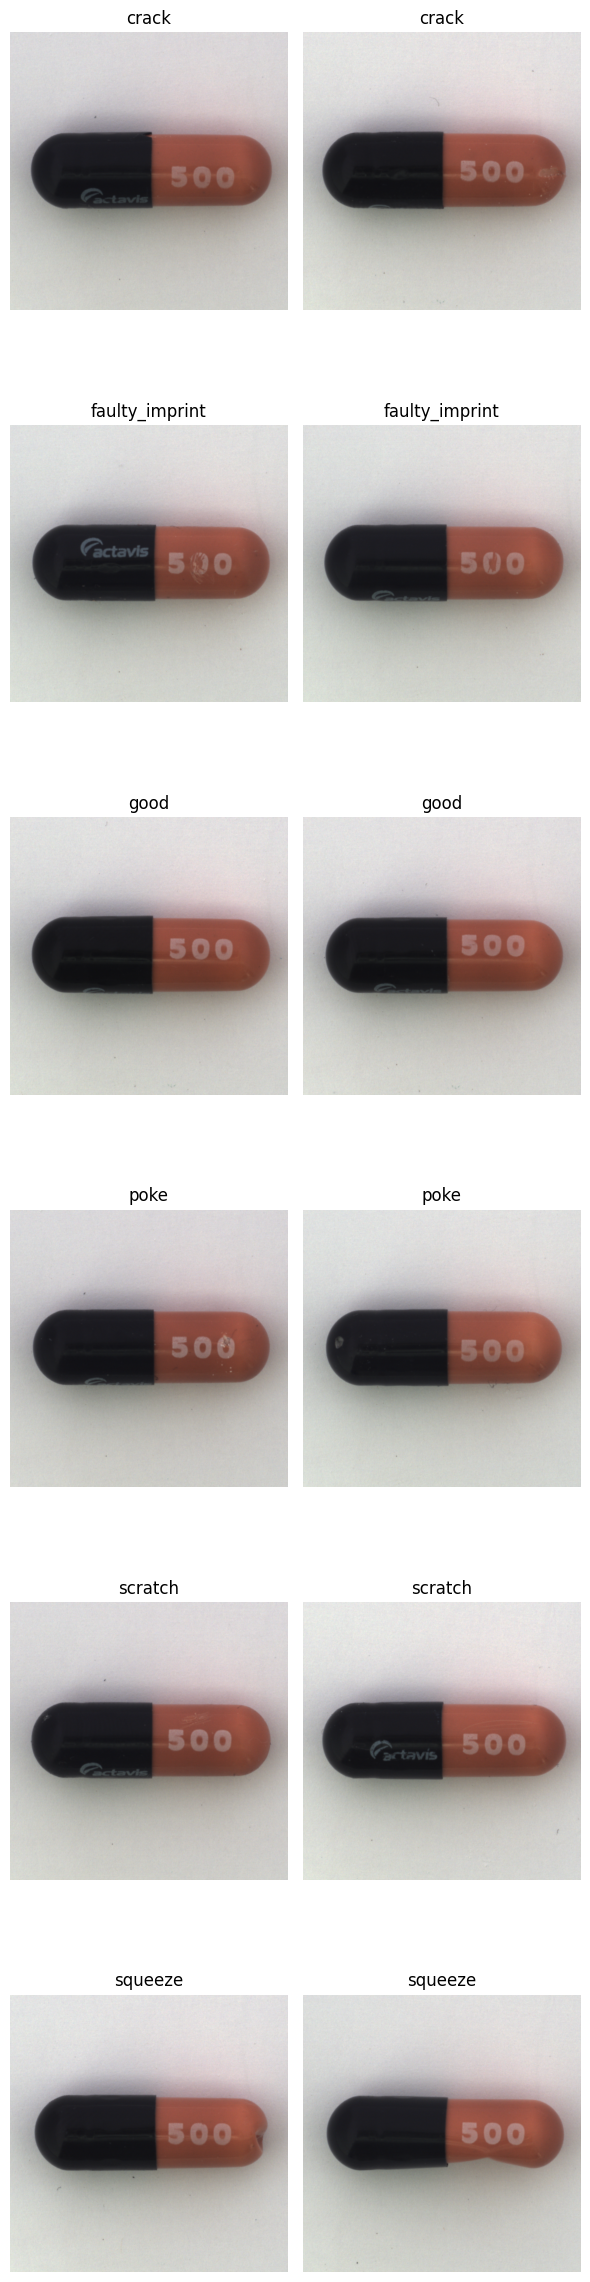

In [3]:
# ✅ 1. 本地圖片根目錄（注意使用 raw string）
base_dir = r'D:\python\DP\HW3\capsule'
splits = ['train', 'test']  # 若只想用 train，改成 ['train']
num_images_per_class = 20  # 設定每個類別要選擇的圖片數量

# ✅ 2. 建立圖片路徑與對應的類別名稱
file_paths = []
labels = []

for split in splits:
    split_dir = os.path.join(base_dir, split)
    for class_name in sorted(os.listdir(split_dir)):
        class_path = os.path.join(split_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        all_img_paths = glob.glob(os.path.join(class_path, '*.png'))
        # 根據 num_images_per_class 設定每個類別選擇的圖片數量
        chosen_img_paths = random.sample(all_img_paths, min(num_images_per_class, len(all_img_paths)))
        file_paths.extend(chosen_img_paths)
        labels.extend([class_name] * len(chosen_img_paths))

# ✅ 3. 讀取圖片（BGR → RGB）
all_data = []
for img_path in tqdm(file_paths, desc="Loading images"):
    img = cv2.imread(img_path)
    img = img[..., ::-1]  # BGR → RGB
    all_data.append(img)

all_data = np.stack(all_data)
labels = np.array(labels)

print(f"讀入圖片總數：{len(all_data)}, shape: {all_data.shape}")
print(f"類別種類：{np.unique(labels)}")

# ✅ 4. 視覺化每個類別隨機選兩張圖片
unique_classes = sorted(set(labels))
fig, axs = plt.subplots(len(unique_classes), 2, figsize=(6, 4 * len(unique_classes)))

for i, cls in enumerate(unique_classes):
    idxs = np.where(labels == cls)[0]
    chosen = random.sample(list(idxs), 2) if len(idxs) >= 2 else list(idxs) * 2
    for j in range(2):
        axs[i, j].imshow(all_data[chosen[j]])
        axs[i, j].set_title(f'{cls}')
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

## A. Data Loading and Preprocessing

In [4]:
num_classes = 7
images_per_class = 20
train_images_per_class = int(images_per_class * 0.8)
val_images_per_class = int(images_per_class * 0.2)

x_train = []
x_val = []

# 假設 all_data 是已經加載並處理過的圖片資料，並且是 (N, H, W, C) 的形狀
# 假設所有資料已經按照類別分割並依照類別順序排列
for i in range(num_classes):
    start_index = i * images_per_class
    x_train.extend(all_data[start_index:start_index + train_images_per_class])
    x_val.extend(all_data[start_index + train_images_per_class:start_index + images_per_class])

# The shape changes from (batch_size, height, width, channels) to (batch_size, channels, height, width)
x_train = np.transpose(np.array(x_train), (0, 3, 1, 2))  # (N, C, H, W)
x_val = np.transpose(np.array(x_val), (0, 3, 1, 2))  # (N, C, H, W)

# 創建對應的標籤
y_train = np.concatenate([np.full(train_images_per_class, i) for i in range(num_classes)])
y_val = np.concatenate([np.full(val_images_per_class, i) for i in range(num_classes)])

# 顯示資料集的形狀
print(f'Shape of x_train: {x_train.shape}')
print(f'Shape of x_val: {x_val.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of y_val: {y_val.shape}')

Shape of x_train: (112, 3, 1000, 1000)
Shape of x_val: (28, 3, 1000, 1000)
Shape of y_train: (112,)
Shape of y_val: (28,)


In [5]:
from PIL import Image

for p in file_paths:
    try:
        img = Image.open(p)
        img.verify()
    except Exception as e:
        print(f"❌ 圖片讀取失敗：{p} | {e}")


In [6]:



# ✅ Transform 定義
train_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.AutoAugment(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

val_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])



class MyImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images  # x_train 或 x_val
        self.labels = labels  # y_train 或 y_val
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # 轉換圖像的維度，從 (C, H, W) 變為 (H, W, C)
        new_x = np.transpose(self.images[idx], (1, 2, 0))
        
        # 將圖像轉換為 PIL 物件，以便於進行 transform
        image = Image.fromarray(new_x)
        
        if self.transform:
            image = self.transform(image)

        return image, self.labels[idx]

# ✅ 使用分割好的資料來創建 Dataset
train_dataset = MyImageDataset(x_train, y_train, transform=train_transforms)
val_dataset = MyImageDataset(x_val, y_val, transform=val_transforms)

# ✅ 使用 DataLoader 載入資料
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,
                          num_workers=0, pin_memory=True, persistent_workers=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False,
                        num_workers=0, pin_memory=True, persistent_workers=False)

# ✅ 顯示資料分布
print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")




Train samples: 112
Val samples: 28


## B. Defining Neural Networks

In [7]:


model = models.resnet18(weights='IMAGENET1K_V1')

# ConvNet as fixed feature extractor (freeze parameters)
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
num_class = 7

# change # of class from 1000 into 8 in the last layer
model.fc = nn.Linear(num_ftrs, num_class)  # 🔹 7 類分類任務

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## C. Training the Neural Network

In [8]:
# 將模型移至 GPU（若可用）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 訓練超參數與損失函數
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader) * 10, eta_min=0)

# 儲存訓練紀錄
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_acc = -1

epochs = 50
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    # 訓練階段
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).long()  # 確保 labels 是 long 類型

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)  # 取得最大機率的類別
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # 驗證階段
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).long()  # 將資料移至 GPU 或 CPU
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)  # 取得最大機率的類別
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100. * correct / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    # 儲存最佳模型
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "baseline.pth")

    # 輸出當前訓練狀態
    print(f"[Epoch {epoch+1:02d}] Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%, Best: {best_val_acc:.2f}%")

[Epoch 01] Train Loss: 2.2465, Train Acc: 12.50%, Val Loss: 1.9898, Val Acc: 10.71%, Best: 10.71%
[Epoch 02] Train Loss: 2.0676, Train Acc: 16.07%, Val Loss: 1.9768, Val Acc: 14.29%, Best: 14.29%
[Epoch 03] Train Loss: 2.0810, Train Acc: 19.64%, Val Loss: 1.9726, Val Acc: 14.29%, Best: 14.29%
[Epoch 04] Train Loss: 2.1066, Train Acc: 16.07%, Val Loss: 1.9709, Val Acc: 14.29%, Best: 14.29%
[Epoch 05] Train Loss: 2.0311, Train Acc: 16.96%, Val Loss: 1.9604, Val Acc: 14.29%, Best: 14.29%
[Epoch 06] Train Loss: 2.0734, Train Acc: 19.64%, Val Loss: 1.9578, Val Acc: 10.71%, Best: 14.29%
[Epoch 07] Train Loss: 2.1466, Train Acc: 16.07%, Val Loss: 1.9606, Val Acc: 10.71%, Best: 14.29%
[Epoch 08] Train Loss: 2.0598, Train Acc: 16.07%, Val Loss: 1.9672, Val Acc: 14.29%, Best: 14.29%
[Epoch 09] Train Loss: 1.9953, Train Acc: 18.75%, Val Loss: 1.9652, Val Acc: 10.71%, Best: 14.29%
[Epoch 10] Train Loss: 2.0897, Train Acc: 11.61%, Val Loss: 1.9498, Val Acc: 14.29%, Best: 14.29%
[Epoch 11] Train Los

### Visualizing model performance

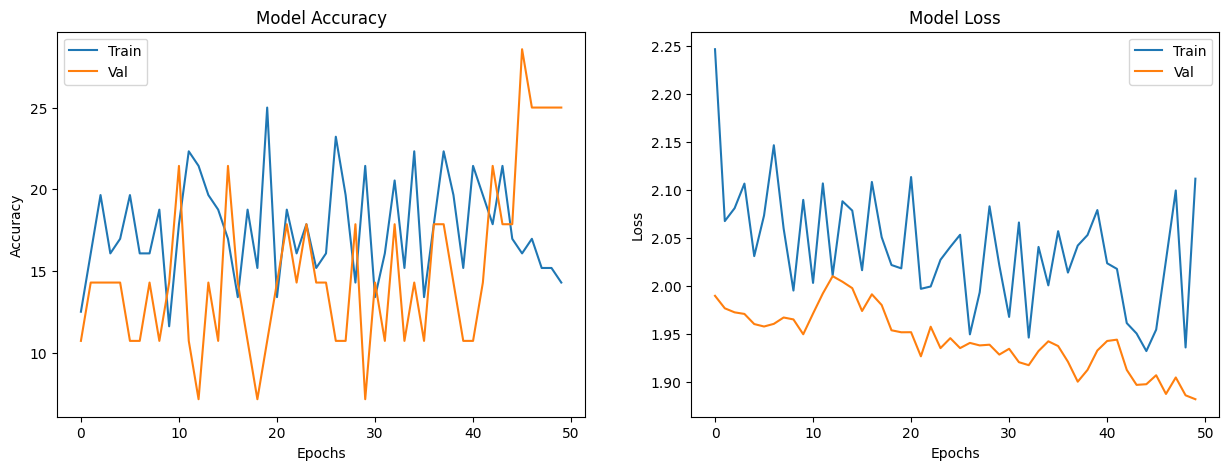

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()

## D. Evaluating Your Trained Model

### Load Trained Model and Evaluate

In [10]:
# Load the trained weights
model.load_state_dict(torch.load('baseline.pth'))

# Set the model to evaluation mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # Ensure the model is on the same device

model.eval()

test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device).long()  # Move data to device and ensure labels are long

        # Forward pass through the model
        outputs = model(images)

        # Get the predicted class (max probability)
        predicted = outputs.argmax(1)

        # Update correct predictions and total samples
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

# Calculate and print the accuracy
test_accuracy = 100. * test_correct / test_total
print(f'Test accuracy is {test_accuracy:.2f}%')


C:\Users\USER\AppData\Local\Temp\ipykernel_30968\3373818945.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('benchmark.pth'))


Test accuracy is 28.57%
